## **1) Title**

# NYC Taxi Fare Estimator

**Goal:** Predict the **total NYC taxi fare** from simple inputs (distance, time/day, passengers, pickup + drop-off zones, and a simple rain flag) and deploy it as a tiny web app.

**Why:** A rider just wants a quick, reasonable price idea before travelling. This project shows a small, practical ML system that goes from data → model → app.


## **2) Setup & Requirements**

- Environment: Google Colab (Python 3)
- Key libraries: pandas, numpy, scikit-learn, matplotlib, joblib
- Dataset: NYC TLC Yellow Taxi (Jan 2025, Parquet). I only load the columns I actually use.
- Reproducibility: simple time-based split; a small “speed mode” so training is fast.


## **3) Install + Imports**

In [26]:
!pip -q install pandas numpy scikit-learn joblib matplotlib pyarrow

import pandas as pd, numpy as np, matplotlib.pyplot as plt
from pathlib import Path
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
import joblib, os

plt.rcParams["figure.figsize"] = (6, 3.5)
plt.rcParams["axes.grid"] = True


## **4) Paths + Data Download**

In [27]:
Path("data").mkdir(exist_ok=True)
Path("models").mkdir(exist_ok=True)
Path("reports/figures").mkdir(parents=True, exist_ok=True)

DATA_URL = "https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2025-01.parquet"
DATA_FILE = Path("data/yellow_2025-01.parquet")

if not DATA_FILE.exists():
    !wget -q -O data/yellow_2025-01.parquet $DATA_URL

print("Data ready at:", DATA_FILE)


Data ready at: data/yellow_2025-01.parquet


## **5) Data Loading**

In [28]:
use_cols = [
    "tpep_pickup_datetime","tpep_dropoff_datetime","passenger_count",
    "trip_distance","fare_amount","total_amount",
    "PULocationID","DOLocationID"
]
df_raw = pd.read_parquet(DATA_FILE, columns=use_cols)
print("Raw shape:", df_raw.shape)
df_raw.head()


Raw shape: (3475226, 8)


,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,fare_amount,total_amount,PULocationID,DOLocationID
0,2025-01-01 00:18:38,2025-01-01 00:26:59,1.0,1.60,10.0,18.00,229,237
1,2025-01-01 00:32:40,2025-01-01 00:35:13,1.0,0.50,5.1,12.12,236,237
2,2025-01-01 00:44:04,2025-01-01 00:46:01,1.0,0.60,5.1,12.10,141,141
3,2025-01-01 00:14:27,2025-01-01 00:20:01,3.0,0.52,7.2,9.70,244,244
4,2025-01-01 00:21:34,2025-01-01 00:25:06,3.0,0.66,5.8,8.30,244,116


## **6) Data Cleaning**

In [29]:
df = df_raw.copy()
df["pickup_datetime"]  = pd.to_datetime(df["tpep_pickup_datetime"])
df["dropoff_datetime"] = pd.to_datetime(df["tpep_dropoff_datetime"])

df = df.dropna(subset=["pickup_datetime","dropoff_datetime","fare_amount","total_amount","trip_distance"])
df = df[(df["fare_amount"] > 0) & (df["fare_amount"] < 200)]
df = df[(df["trip_distance"] > 0) & (df["trip_distance"] < 100)]

df["passenger_count"] = df["passenger_count"].fillna(1).clip(1, 6)

df = df[["pickup_datetime","trip_distance","passenger_count","fare_amount","total_amount","PULocationID","DOLocationID"]].copy()
print("After cleaning:", df.shape)
df.head()


After cleaning: (3252846, 7)


,pickup_datetime,trip_distance,passenger_count,fare_amount,total_amount,PULocationID,DOLocationID
0,2025-01-01 00:18:38,1.60,1.0,10.0,18.00,229,237
1,2025-01-01 00:32:40,0.50,1.0,5.1,12.12,236,237
2,2025-01-01 00:44:04,0.60,1.0,5.1,12.10,141,141
3,2025-01-01 00:14:27,0.52,3.0,7.2,9.70,244,244
4,2025-01-01 00:21:34,0.66,3.0,5.8,8.30,244,116


## **7) Exploratory Data Analysis**

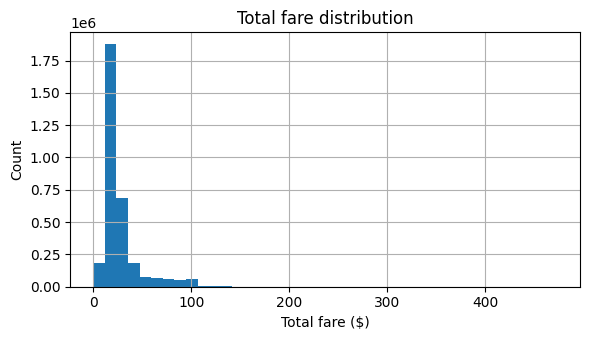

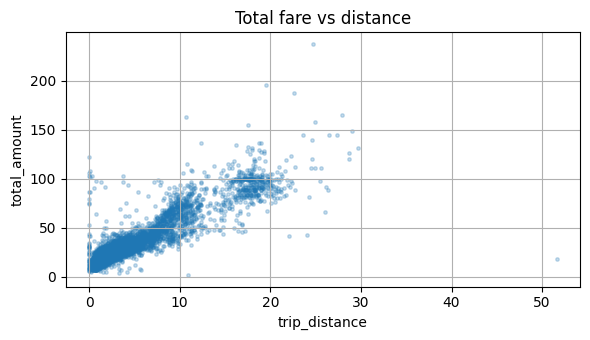

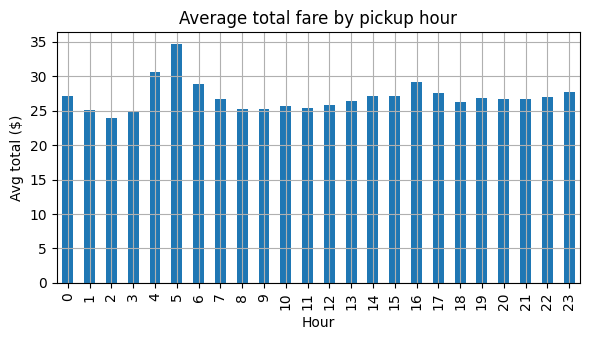

In [52]:
# 1) Fare histogram (total_amount)
df["total_amount"].hist(bins=40)
plt.title("Total fare distribution")
plt.xlabel("Total fare ($)"); plt.ylabel("Count")
plt.tight_layout(); plt.savefig("total_hist.png", dpi=150); plt.show()

# 2) Total vs distance (sample)
s = df.sample(min(len(df), 10_000), random_state=42)
s.plot.scatter(x="trip_distance", y="total_amount", s=6, alpha=0.25)
plt.title("Total fare vs distance")
plt.tight_layout(); plt.savefig("total_vs_distance.png", dpi=150); plt.show()

# 3) Average total by pickup hour
hr = df["pickup_datetime"].dt.hour
avg = df.groupby(hr)["total_amount"].mean()
avg.plot(kind="bar")
plt.title("Average total fare by pickup hour")
plt.xlabel("Hour"); plt.ylabel("Avg total ($)")
plt.tight_layout(); plt.savefig("avg_total_by_hour.png", dpi=150); plt.show()


## **7) Features**

In [31]:
# pickup/drop-off zones
top_pu = set(df["PULocationID"].value_counts().head(12).index)
top_do = set(df["DOLocationID"].value_counts().head(12).index)
df["pickup_zone"]  = df["PULocationID"].apply(lambda x: f"Z{x}" if x in top_pu else "Other")
df["dropoff_zone"] = df["DOLocationID"].apply(lambda x: f"Z{x}" if x in top_do else "Other")

# simple rain flag (demo): mark every 5th date as rainy
df["date"] = df["pickup_datetime"].dt.date
dates = pd.Series(pd.unique(df["date"])).sort_values()
rainy = set(dates[::5])
df["is_rain"] = df["date"].apply(lambda d: 1 if d in rainy else 0)

# numeric + time features
Xy = pd.DataFrame({
    "trip_distance_km": df["trip_distance"]*1.60934,
    "pickup_hour": df["pickup_datetime"].dt.hour,
    "passenger_count": df["passenger_count"],
    "pickup_weekday": df["pickup_datetime"].dt.weekday,
    "is_weekend": (df["pickup_datetime"].dt.weekday >= 5).astype(int),
    "is_rush_hour": df["pickup_datetime"].dt.hour.isin([7,8,9,16,17,18,19]).astype(int),
    "pickup_zone": df["pickup_zone"],
    "dropoff_zone": df["dropoff_zone"],
    "is_rain": df["is_rain"].astype(int),
    "pickup_datetime": df["pickup_datetime"],
    "total_amount": df["total_amount"]
})
FEATS_NUM = ["trip_distance_km","pickup_hour","passenger_count"]
FEATS_CAT = ["pickup_weekday","is_weekend","is_rush_hour","pickup_zone","dropoff_zone","is_rain"]
TARGET = "total_amount"

print("Top pickup zones for app:", sorted({f"Z{z}" for z in top_pu}) + ["Other"])
print("Top dropoff zones for app:", sorted({f"Z{z}" for z in top_do}) + ["Other"])


Top pickup zones for app: ['Z132', 'Z142', 'Z161', 'Z162', 'Z163', 'Z170', 'Z186', 'Z230', 'Z234', 'Z236', 'Z237', 'Z239', 'Other']
Top dropoff zones for app: ['Z141', 'Z142', 'Z161', 'Z162', 'Z163', 'Z170', 'Z230', 'Z234', 'Z236', 'Z237', 'Z239', 'Z68', 'Other']


## **8) Split + speed mode**

In [32]:
latest = Xy["pickup_datetime"].dt.date.max()
cut = pd.Timestamp(latest) - pd.Timedelta(days=3)
train = Xy[Xy["pickup_datetime"] < cut].copy()
valid = Xy[Xy["pickup_datetime"] >= cut].copy()

SPEED_MODE = True
TRAIN_MAX, VALID_MAX = 200_000, 50_000
if SPEED_MODE:
    train = train.sample(n=min(TRAIN_MAX, len(train)), random_state=42)
    valid = valid.sample(n=min(VALID_MAX, len(valid)), random_state=42)

X_train, y_train = train[FEATS_NUM + FEATS_CAT], train[TARGET]
X_valid, y_valid = valid[FEATS_NUM + FEATS_CAT], valid[TARGET]
print("Train rows:", len(train), "| Valid rows:", len(valid))


Train rows: 200000 | Valid rows: 50000


## **9) Train two models**

In [33]:
pre = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), FEATS_CAT),
        ("num", "passthrough", FEATS_NUM),
    ],
    remainder="drop"
)

lin = Pipeline([("pre", pre), ("m", LinearRegression())]).fit(X_train, y_train)
lin_mae = mean_absolute_error(y_valid, lin.predict(X_valid))

rf  = Pipeline([("pre", pre), ("m", RandomForestRegressor(
    n_estimators=120, max_depth=12, min_samples_leaf=5, n_jobs=-1, random_state=42
))]).fit(X_train, y_train)
rf_mae = mean_absolute_error(y_valid, rf.predict(X_valid))

print(f"Linear MAE:       ${lin_mae:.2f}")
print(f"RandomForest MAE: ${rf_mae:.2f}")

best = rf if rf_mae <= lin_mae else lin


Linear MAE:       $4.01
RandomForest MAE: $3.59


## **10) One plot + save model**

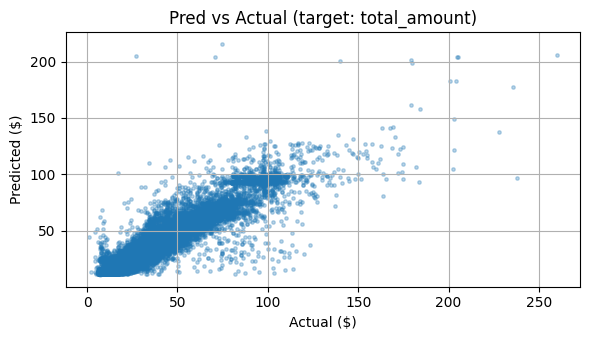

Saved model to models/model_v2.pkl


In [42]:
preds = best.predict(X_valid)
plt.scatter(y_valid, preds, s=6, alpha=0.3)
plt.title("Pred vs Actual (target: total_amount)")
plt.xlabel("Actual ($)"); plt.ylabel("Predicted ($)")
plt.tight_layout(); plt.savefig("reports/figures/pred_vs_actual_total.png", dpi=160); plt.show()


joblib.dump(best, "models/model_v2.pkl")
print("Saved model to models/model_v2.pkl")


In [51]:
from google.colab import files
files.download("models/model_v2.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## **11) Conclusion**

Distance explains most of the total fare, but adding **pickup + drop-off zones** and simple time/weather flags gives small, sensible price shifts. The compact model is fast to run and easy to demo in a Streamlit app. Next steps would be to join real weather and surcharges, and consider tolls/airport flags to capture bigger effects.
